In [3]:
%pip install astroquery scienceplots

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached jaraco.classes-3.4.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached jaraco.context-6.0.1-py3-none-any.whl.metadata (4.1 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.6.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 49.8 MB/s  0:00:00m0:00:01
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.2 MB/s  0:00:00
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached idna-3.11-py3-none-any.whl (71 kB)
Using cached urllib3-2.6.2-py3-none-any.whl (131 kB)
Using cached certifi-2025.11.12-py3-none-any.whl (159 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Foreground Galaxy Identification for FRB Sample (v2.0)

This notebook identifies foreground galaxies for a sample of 12 FRBs by querying astronomical catalogs and calculating physical impact parameters. It utilizes the modular `v2.0` galaxy search toolkit.

In [6]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord

# Add the project root to sys.path to import the v2_0 module
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import v2_0 components
from galaxies.v2_0.config import TARGETS, DEFAULT_IMPACT_KPC
from galaxies.v2_0.utils import parse_coord, get_angular_radius, calculate_impact_parameter
from galaxies.v2_0.engines import NedEngine, VizierEngine
from galaxies.v2_0.plotting import use_flits_style, plot_impact_vs_redshift, plot_sightline

# Apply style
use_flits_style()

print(f"Loaded {len(TARGETS)} targets.")


Loaded 12 targets.


In [8]:
import os
print(os.getcwd())
print(os.listdir('.'))
print(os.listdir('../..'))


/data/jfaber/dsa110-FLITS/galaxies/v2_0
['engines.py', 'search.py', '__pycache__', '__init__.py', 'analysis.ipynb', 'utils.py', 'plotting.py', 'config.py', 'test_engines.py']
['environment.yml', '.archive', 'simulation', 'galaxies', '.codacy', '.cursor', 'results', 'scattering', '.gemini', 'tests', '.gitignore', 'README.md', '.deprecated', 'animations', 'scintillation', '.git', 'requirements.txt', 'dispersion', 'flits', 'ONBOARDING_STATUS_REPORT.md', '.pytest_cache', 'analyses', 'papers', 'crossmatching', 'configs', 'LICENSE', 'pyproject.toml', '.github', 'FLITS-Complete-Agent-Configuration-Guide.md', 'docs', 'scripts']


## 2. Loading FRB Sample Coordinates

We load the metadata for the 12 FRBs into a pandas DataFrame for easier manipulation.

In [ ]:
frb_df = pd.DataFrame(TARGETS, columns=['ra_str', 'dec_str', 'z_frb'])
frb_df['target_id'] = range(1, len(frb_df) + 1)

# Parse coordinates to decimal degrees
coords = [parse_coord(r, d) for r, d in zip(frb_df.ra_str, frb_df.dec_str)]
frb_df['ra_deg'] = [c.ra.deg for c in coords]
frb_df['dec_deg'] = [c.dec.deg for c in coords]

frb_df.head()

## 3. Querying Galaxy Catalogs

We use the `NedEngine` and `VizierEngine` to search for galaxies around each FRB. For this demonstration, we'll search around the first target.

In [ ]:
# Select first target
target = frb_df.iloc[0]
coord = parse_coord(target.ra_str, target.dec_str)
radius = get_angular_radius(target.z_frb, DEFAULT_IMPACT_KPC)

print(f"Searching around Target 1 (z={target.z_frb}) with radius {radius:.2f}")

# Initialize engines
ned = NedEngine()
# Query NED
ned_results = ned.query(coord, radius)

print(f"Found {len(ned_results)} results in NED.")
ned_results.head()

## 4. Calculating Angular and Physical Separations

We calculate the physical impact parameter $b$ for each galaxy using the angular diameter distance $d_A$ at the galaxy's redshift.

In [ ]:
if not ned_results.empty:
    ned_results['impact_kpc'] = ned_results.apply(
        lambda row: calculate_impact_parameter(
            row['ra'], row['dec'], row['z'], target.ra_deg, target.dec_deg
        ), axis=1
    )
    
ned_results.head()

## 5. Identifying Foreground Galaxy Candidates

We filter for galaxies where $z_{gal} < z_{frb}$ and the impact parameter is within our threshold (e.g., 100 kpc).

In [ ]:
foreground_galaxies = ned_results[
    (ned_results['z'] < target.z_frb) & 
    (ned_results['impact_kpc'] <= DEFAULT_IMPACT_KPC)
]

print(f"Found {len(foreground_galaxies)} foreground galaxy candidates.")
foreground_galaxies.head()

## 6. Visualizing FRB-Galaxy Environments

We plot the distribution of galaxies around the FRB sightline.

/tmp/ipykernel_819466/1254766444.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_galaxies_df = pd.concat(all_galaxies, ignore_index=True)


Loaded 7 galaxies across all targets.


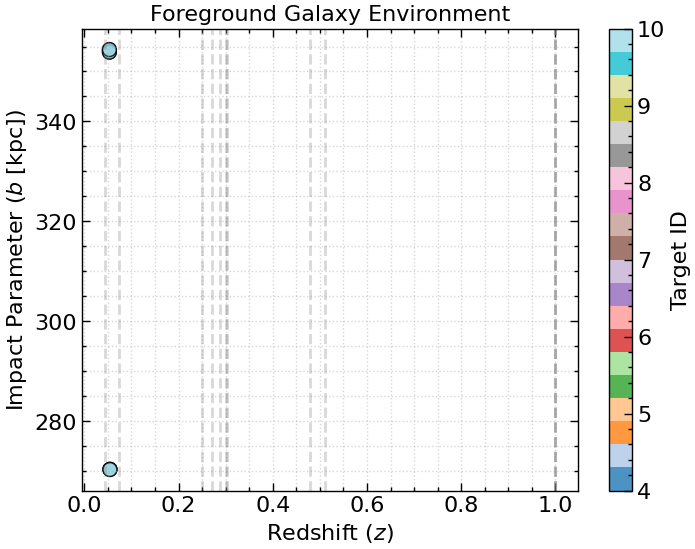

IndexError: single positional indexer is out-of-bounds

In [ ]:
from galaxies.v2_0.plotting import plot_impact_vs_redshift, plot_sightline

# Use absolute paths
root_dir = '/data/jfaber/dsa110-FLITS'
results_dir = os.path.join(root_dir, 'results')

# Load summary
summary_path = os.path.join(results_dir, 'search_summary.csv')
if os.path.exists(summary_path):
    summary_df = pd.read_csv(summary_path)
    print("Summary loaded. Target IDs present:", summary_df['target_id'].unique())

    # Load all galaxies
    all_galaxies = []
    for i in range(1, 13):
        path = os.path.join(results_dir, f'target_{i}_galaxies.csv')
        if os.path.exists(path):
            df = pd.read_csv(path)
            df['target_id'] = i
            all_galaxies.append(df)

    if all_galaxies:
        all_galaxies_df = pd.concat(all_galaxies, ignore_index=True)
        print(f"Loaded {len(all_galaxies_df)} galaxies across all targets.")
        
        # 1. Summary Plot
        fig1, ax1 = plot_impact_vs_redshift(summary_df, all_galaxies_df, output_path=os.path.join(results_dir, 'impact_vs_redshift.png'))
        plt.show()
        
        # 2. Sightline Plot for a target with results
        targets_with_results = all_galaxies_df['target_id'].unique()
        if len(targets_with_results) > 0:
            tid = targets_with_results[0]
            print(f"Generating sightline plot for Target {tid}")
            target_info = summary_df[summary_df['target_id'] == tid].iloc[0].to_dict()
            target_galaxies = all_galaxies_df[all_galaxies_df['target_id'] == tid]
            
            fig2, ax2 = plot_sightline(target_info, target_galaxies, output_path=os.path.join(results_dir, f'target_{tid}_sightline.png'))
            plt.show()
    else:
        print("No foreground galaxies found to plot.")
else:
    print(f"Summary file not found at {summary_path}")


## 7. Exporting Foreground Galaxy Catalog

Finally, we save the identified foreground galaxies to a CSV file.

In [ ]:
if not foreground_galaxies.empty:
    foreground_galaxies.to_csv('foreground_galaxies_v2.csv', index=False)
    print("Saved foreground galaxies to foreground_galaxies_v2.csv")